#Regresi

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from sklearn.datasets import load_iris, make_blobs, fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator

In [ ]:
# membuat sesi spark
spark = SparkSession.builder.appName("pertemuan pyspark").getOrCreate()

In [ ]:
# load dataset
california = fetch_california_housing()
california_df = pd.DataFrame(california.data,
                             columns=california.feature_names)
california_df['target'] = california.target

In [ ]:
# convert ke PySpark DataFrame
spark_california_df = spark.createDataFrame(california_df)

In [ ]:
spark_california_df.show(15)

+------+--------+------------------+------------------+----------+------------------+--------+---------+------+
|MedInc|HouseAge|          AveRooms|         AveBedrms|Population|          AveOccup|Latitude|Longitude|target|
+------+--------+------------------+------------------+----------+------------------+--------+---------+------+
|8.3252|    41.0| 6.984126984126984|1.0238095238095237|     322.0|2.5555555555555554|   37.88|  -122.23| 4.526|
|8.3014|    21.0| 6.238137082601054|0.9718804920913884|    2401.0| 2.109841827768014|   37.86|  -122.22| 3.585|
|7.2574|    52.0| 8.288135593220339| 1.073446327683616|     496.0|2.8022598870056497|   37.85|  -122.24| 3.521|
|5.6431|    52.0|5.8173515981735155|1.0730593607305936|     558.0| 2.547945205479452|   37.85|  -122.25| 3.413|
|3.8462|    52.0| 6.281853281853282|1.0810810810810811|     565.0|2.1814671814671813|   37.85|  -122.25| 3.422|
|4.0368|    52.0| 4.761658031088083|1.1036269430051813|     413.0| 2.139896373056995|   37.85|  -122.25|

In [ ]:
spark_california_df.printSchema()

root
 |-- MedInc: double (nullable = true)
 |-- HouseAge: double (nullable = true)
 |-- AveRooms: double (nullable = true)
 |-- AveBedrms: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- AveOccup: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- target: double (nullable = true)



In [ ]:
spark_california_df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|            MedInc|          HouseAge|          AveRooms|         AveBedrms|        Population|          AveOccup|          Latitude|          Longitude|            target|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|  count|             20640|             20640|             20640|             20640|             20640|             20640|             20640|              20640|             20640|
|   mean| 3.870671002906976|28.639486434108527| 5.428999742190385| 1.096675149606209|1425.4767441860465|3.0706551594363716|  35.6318614341086|-119.56970445736394|2.0685581690891293|
| stddev|1.8998217179452666|12.585557612111632|2.4741731394243245|0.4739108567954673|1132.

In [ ]:
# preprocessing
assembler = VectorAssembler (inputCols=california.feature_names,
                             outputCol="features")
spark_california_df = assembler.transform(
    spark_california_df).select("features", "target")

In [ ]:
spark_california_df.show(5)

+--------------------+------+
|            features|target|
+--------------------+------+
|[8.3252,41.0,6.98...| 4.526|
|[8.3014,21.0,6.23...| 3.585|
|[7.2574,52.0,8.28...| 3.521|
|[5.6431,52.0,5.81...| 3.413|
|[3.8462,52.0,6.28...| 3.422|
+--------------------+------+
only showing top 5 rows


In [ ]:
train, test = spark_california_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="target")
lr_model = lr.fit(train)
predictions = lr_model.transform(test)
print("prediksi Regresi:")
predictions.show()

prediksi Regresi:
+--------------------+-------+--------------------+
|            features| target|          prediction|
+--------------------+-------+--------------------+
|[0.4999,28.0,7.67...|5.00001|  0.8636611002081835|
|[0.4999,52.0,2.6,...|  0.906|  1.0207615146533868|
|[0.536,16.0,4.5,1...|    3.5|   1.091494549716252|
|[0.6775,52.0,1.74...|    3.5|  1.5128374133887448|
|[0.7403,37.0,4.49...|  0.686|  1.1569189315147597|
|[0.76,10.0,2.6515...|  1.625|  1.0887481760842306|
|[0.8026,23.0,5.36...|  1.125|  0.9722254546464413|
|[0.8185,13.0,2.49...|  1.875|  0.9692636883896455|
|[0.8585,15.0,4.82...|   0.45| -0.1640116290411484|
|[0.8639,28.0,4.28...|  0.494|  0.7026276336935879|
|[0.8641,37.0,4.07...|  0.842|  1.2293545554076815|
|[0.8702,11.0,3.71...|  1.705|   0.794182512483097|
|[0.8907,34.0,2.28...|  1.542|  0.9605594770829953|
|[0.8964,24.0,5.72...|  0.592|-0.02265069454171...|
|[0.9234,40.0,2.73...|  1.875|  1.5398923505879978|
|[0.9337,45.0,4.71...|  0.923|  1.172024787496

In [ ]:
regressor_evaluator = RegressionEvaluator(labelCol="target",
                                           predictionCol="prediction",
                                           metricName="rmse")
rmse = regressor_evaluator.evaluate(predictions)
print("RMSE:", rmse)

r2_evaluator = RegressionEvaluator(labelCol="target",
                                  predictionCol="prediction",
                                  metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print("R2:", r2)

RMSE: 0.733293906676871
R2: 0.5863933868971052


# Klasifikasi


In [ ]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

In [ ]:
# convert ke Pyspark DataFrame
spark_iris_df = spark.createDataFrame(iris_df)

In [ ]:
spark_iris_df.printSchema()

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- target: long (nullable = true)



In [ ]:
spark_iris_df.show(10)

+-----------------+----------------+-----------------+----------------+------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target|
+-----------------+----------------+-----------------+----------------+------+
|              5.1|             3.5|              1.4|             0.2|     0|
|              4.9|             3.0|              1.4|             0.2|     0|
|              4.7|             3.2|              1.3|             0.2|     0|
|              4.6|             3.1|              1.5|             0.2|     0|
|              5.0|             3.6|              1.4|             0.2|     0|
|              5.4|             3.9|              1.7|             0.4|     0|
|              4.6|             3.4|              1.4|             0.3|     0|
|              5.0|             3.4|              1.5|             0.2|     0|
|              4.4|             2.9|              1.4|             0.2|     0|
|              4.9|             3.1|              1.

In [ ]:
spark_iris_df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary| sepal length (cm)|  sepal width (cm)| petal length (cm)|  petal width (cm)|            target|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               150|               150|               150|               150|               150|
|   mean| 5.843333333333332|3.0573333333333337| 3.758000000000001|1.1993333333333331|               1.0|
| stddev|0.8280661279778628|0.4358662849366982|1.7652982332594664|0.7622376689603467|0.8192319205190403|
|    min|               4.3|               2.0|               1.0|               0.1|                 0|
|    max|               7.9|               4.4|               6.9|               2.5|                 2|
+-------+------------------+------------------+------------------+------------------+------------------+



In [ ]:
# preprocessing
assembler = VectorAssembler (inputCols=iris.feature_names,
                             outputCol="features")
spark_iris_df = assembler.transform(
    spark_iris_df).select("features", "target")

In [ ]:
spark_iris_df.show()

+-----------------+------+
|         features|target|
+-----------------+------+
|[5.1,3.5,1.4,0.2]|     0|
|[4.9,3.0,1.4,0.2]|     0|
|[4.7,3.2,1.3,0.2]|     0|
|[4.6,3.1,1.5,0.2]|     0|
|[5.0,3.6,1.4,0.2]|     0|
|[5.4,3.9,1.7,0.4]|     0|
|[4.6,3.4,1.4,0.3]|     0|
|[5.0,3.4,1.5,0.2]|     0|
|[4.4,2.9,1.4,0.2]|     0|
|[4.9,3.1,1.5,0.1]|     0|
|[5.4,3.7,1.5,0.2]|     0|
|[4.8,3.4,1.6,0.2]|     0|
|[4.8,3.0,1.4,0.1]|     0|
|[4.3,3.0,1.1,0.1]|     0|
|[5.8,4.0,1.2,0.2]|     0|
|[5.7,4.4,1.5,0.4]|     0|
|[5.4,3.9,1.3,0.4]|     0|
|[5.1,3.5,1.4,0.3]|     0|
|[5.7,3.8,1.7,0.3]|     0|
|[5.1,3.8,1.5,0.3]|     0|
+-----------------+------+
only showing top 20 rows


In [ ]:
train, test = spark_iris_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
lr = LogisticRegression(featuresCol="features",
                        labelCol="target", maxIter=10)
lr_model = lr.fit(train)
predictions = lr_model.transform(test)
print("prediksi Klasifikasi:")
predictions.show()

prediksi Klasifikasi:
+-----------------+------+--------------------+--------------------+----------+
|         features|target|       rawPrediction|         probability|prediction|
+-----------------+------+--------------------+--------------------+----------+
|[4.4,3.0,1.3,0.2]|     0|[18.4881102722326...|[0.99997956637236...|       0.0|
|[4.6,3.2,1.4,0.2]|     0|[18.6731364276534...|[0.99997845923892...|       0.0|
|[4.6,3.6,1.0,0.2]|     0|[22.5439678867162...|[0.99999953371617...|       0.0|
|[4.8,3.1,1.6,0.2]|     0|[16.5922527329727...|[0.99974667589489...|       0.0|
|[4.9,3.1,1.5,0.2]|     0|[16.5135751261617...|[0.99961967633528...|       0.0|
|[5.0,3.2,1.2,0.2]|     0|[17.7212122562142...|[0.99982614479709...|       0.0|
|[5.0,3.6,1.4,0.2]|     0|[19.6804024826906...|[0.99998492590785...|       0.0|
|[5.1,3.8,1.5,0.3]|     0|[19.5765019043532...|[0.99998680030949...|       0.0|
|[5.4,3.7,1.5,0.2]|     0|[18.4217586876262...|[0.99988230608514...|       0.0|
|[5.4,3.9,1.3,0.4]

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="target",
                                           predictionCol="prediction",
                                           metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Akurasi: {accuracy}" )

Akurasi: 1.0


# Clustering


In [ ]:
# load dataset
X, _ = make_blobs(
    n_samples=300,
    centers=3,
    cluster_std=1,
    random_state=42
)
blobs_df = pd.DataFrame(
    X,
    columns=['Feature1', 'Feature2']
)

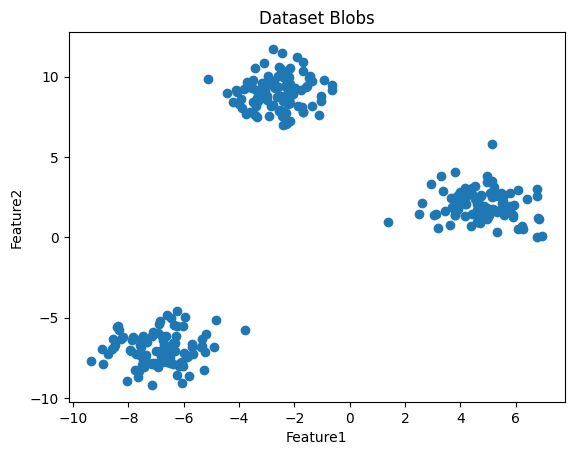

In [ ]:
plt.scatter(blobs_df['Feature1'], blobs_df['Feature2'])
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Dataset Blobs')
plt.show()

In [ ]:
# convert ke PySpark DataFrame
spark_blobs_df = spark.createDataFrame(blobs_df)

In [ ]:
spark_blobs_df.printSchema()

root
 |-- Feature1: double (nullable = true)
 |-- Feature2: double (nullable = true)



In [ ]:
spark_blobs_df.describe().show()

+-------+-------------------+------------------+
|summary|           Feature1|          Feature2|
+-------+-------------------+------------------+
|  count|                300|               300|
|   mean|-1.5900003646034588| 1.356726636034251|
| stddev|   4.91128429549514|6.6418786697912875|
|    min| -9.351271691278559|-9.182030758011532|
|    max|   6.95453740290161| 11.73445529478794|
+-------+-------------------+------------------+



In [ ]:
# preprocessing
assembler = VectorAssembler (inputCols = ['Feature1', 'Feature2'],
                             outputCol = 'features')
spark_blobs_df = assembler.transform(
    spark_blobs_df).select('features')

In [ ]:
Kmeans = KMeans (featuresCol="features", k=3, seed=42)
Kmeans_model = Kmeans.fit(spark_blobs_df)
predictions = Kmeans_model.transform(spark_blobs_df)
print("Prediksi Clustering:")
predictions.show()

Prediksi Clustering:
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-7.3389880906915...|         1|
|[-7.7400405564352...|         1|
|[-1.6866527109495...|         2|
|[4.42219763300088...|         0|
|[-8.9177517263291...|         1|
|[5.49753845943012...|         0|
|[-2.3360166972015...|         2|
|[5.05281029050372...|         0|
|[-2.9883718608980...|         2|
|[-3.7005011202553...|         2|
|[-3.1109042352821...|         2|
|[4.99689432219314...|         0|
|[-2.3003340280479...|         2|
|[-3.9245683651031...|         2|
|[-7.5302697602730...|         1|
|[-3.2112507169301...|         2|
|[-8.5071696290344...|         1|
|[2.61473624957049...|         0|
|[-2.4121200737047...|         2|
|[-1.9223405292524...|         2|
+--------------------+----------+
only showing top 20 rows


In [ ]:
clustering_evaluator = ClusteringEvaluator(predictionCol = "prediction",
                                          metricName= "silhouette")
silhouette = clustering_evaluator.evaluate(predictions)
print(f"Silhoutte Score: {silhouette}")

Silhoutte Score: 0.9696628776463792
